<a href="https://colab.research.google.com/github/shahriariit/COVID-19-Xray/blob/master/COVID19_XRay_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
from PIL import Image
from scipy import misc

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [0]:
import pandas as pd 
train = pd.read_csv('radiography.csv')
print(train.shape)
 

(657, 10001)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from sklearn.utils import shuffle
train = shuffle(train)

In [0]:
X = train.iloc[:, 1:]
X  = X / 255.0
y  = train[['10001']]

In [0]:

 # Reshape and normalize training data
X = train.iloc[:, 1:]
X = X.values.reshape(train.shape[0],100, 100,1).astype( 'float32' )
X  = X / 255.0

y  = train[['10001']] 

In [0]:
 
 from keras.utils import np_utils
 train


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000,10001
535,56,63,64,63,66,65,65,63,59,54,46,44,38,34,23,15,11,5,0,0,0,0,0,0,0,0,0,4,15,38,38,43,153,177,179,201,205,207,205,219,...,215,217,216,217,218,218,218,218,217,217,217,218,215,212,212,211,214,209,211,213,211,211,207,201,195,192,187,186,184,183,175,176,150,65,24,0,0,0,2,2
639,17,14,13,13,12,13,14,19,15,13,13,13,14,15,13,13,14,15,16,16,19,19,18,20,18,20,35,33,12,13,13,13,12,6,0,7,35,49,71,72,...,150,152,148,147,133,129,143,139,141,136,135,140,146,155,158,152,150,144,134,119,92,87,73,51,3,14,17,19,20,21,21,21,19,20,18,17,27,62,158,2
374,22,37,53,63,72,75,77,80,138,114,115,110,147,79,76,76,74,76,75,72,65,55,37,36,23,11,0,0,0,0,12,25,70,84,105,121,122,132,144,212,...,199,201,211,213,199,193,192,200,193,196,192,193,189,183,186,183,183,192,187,189,183,174,161,149,119,101,142,106,56,34,0,0,0,0,0,0,0,0,0,1
642,0,0,15,32,44,55,60,65,66,115,105,110,108,109,114,125,90,62,75,71,78,90,84,85,71,81,90,91,105,97,98,103,104,104,92,94,97,97,90,106,...,195,183,187,180,189,185,187,184,183,198,196,199,200,195,191,182,174,184,178,177,178,161,163,159,149,143,140,148,144,157,126,86,122,73,0,0,0,0,0,2
481,66,72,76,115,127,122,125,127,129,120,121,126,120,127,119,107,128,122,115,113,108,113,91,91,88,82,78,64,52,40,41,207,214,213,210,214,210,211,212,217,...,181,180,185,182,184,189,187,195,190,192,192,184,187,184,183,182,178,179,177,178,177,173,172,179,176,179,169,157,145,136,167,142,88,53,31,11,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,138,58,57,75,83,94,97,137,136,130,126,130,192,105,107,99,99,99,97,95,86,74,64,53,34,0,5,6,5,1,0,36,83,99,110,117,131,137,172,187,...,227,225,222,219,226,222,216,202,204,203,214,220,204,213,208,194,222,211,223,225,227,221,218,215,218,213,211,202,198,184,165,130,72,83,81,88,90,94,97,1
445,0,1,230,14,31,54,66,80,94,105,101,104,109,130,139,149,143,156,153,152,146,156,156,167,188,197,193,205,206,214,192,191,197,196,196,203,202,200,205,204,...,182,181,182,180,175,173,169,166,165,164,164,165,171,171,173,177,173,176,174,173,162,154,146,130,114,164,128,61,24,2,0,0,0,0,0,0,0,0,0,2
604,22,25,26,30,46,30,34,36,37,36,41,45,42,43,41,37,38,32,50,89,97,100,110,115,121,124,124,127,135,137,140,143,151,155,179,167,169,174,176,175,...,153,148,159,166,158,159,154,150,145,151,143,142,136,131,127,123,121,118,118,118,114,110,110,104,103,85,63,42,34,29,21,0,0,0,2,4,5,5,5,2
363,0,0,0,8,18,23,28,33,40,53,48,57,62,128,115,109,110,115,123,105,90,71,85,81,74,100,207,217,216,204,197,200,255,234,253,253,255,255,255,255,...,252,252,251,250,245,246,243,249,250,245,253,252,255,254,246,242,235,232,234,229,227,218,214,216,209,209,192,154,155,155,140,52,19,0,0,0,0,0,0,1


In [0]:

from keras.utils import to_categorical
y = to_categorical(y)
y.shape

(657, 3)

In [0]:
def cnn_model(size, num_cnn_layers):
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 120
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))
  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(int(MAX_NEURONS/2), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #print(model.summary())
    
    return model

In [0]:
 IMAGE_SIZE = (100, 100, 1)
 model = cnn_model(IMAGE_SIZE, 2)

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 120)               19200120  
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 60)               

In [0]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model(IMAGE_SIZE, 2) 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y)) 
    return results 

In [0]:
n_folds= 3
epochs= 8
batch_size=15

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 531 samples, validate on 60 samples
Epoch 1/8
531/531 [==============================] - 24s 45ms/step - loss: 0.8824 - accuracy: 0.6460 - val_loss: 0.3625 - val_accuracy: 0.8833

Epoch 00001: val_loss improved from inf to 0.36246, saving model to fas_mnist_1.h5
Epoch 2/8
531/531 [==============================] - 23s 44ms/step - loss: 0.3004 - accuracy: 0.9002 - val_loss: 0.2224 - val_accuracy: 0.9000

Epoch 00002: val_loss improved from 0.36246 to 0.22238, saving model to fas_mnist_1.h5
Epoch 3/8
531/531 [==============================] - 24s 45ms/step - loss: 0.1361 - accuracy: 0.9397 - val_loss: 0.1941 - val_accuracy: 0.9333

Epoch 00003: val_loss improved from 0.22238 to 0.19413, saving model to fas_mnist_1.h5
Epoch 4/8
531/531 [==============================] - 24s 45ms/step - loss: 0.1017 - accuracy: 0.9680 - val_loss: 0.3153 - val_accuracy: 0.9000

Epoch 00004: val_loss did not improve from 0.19413
Epoch 5/8
531/531 [==============================]

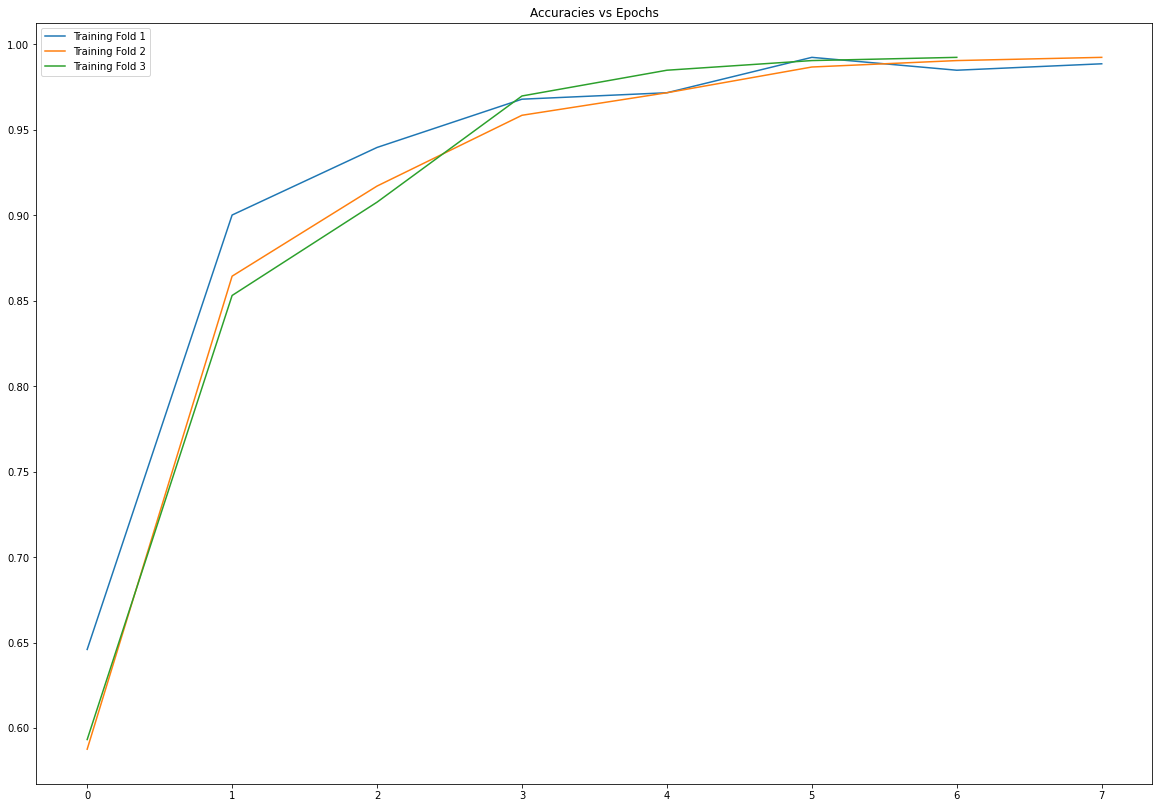

In [0]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')

plt.legend()
plt.show()

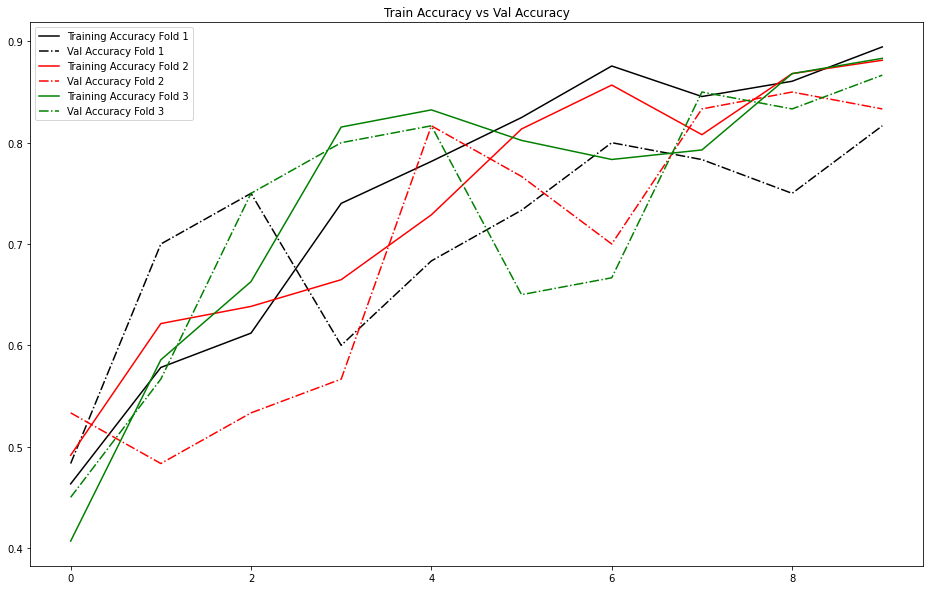

In [0]:
plt.title('Train Accuracy vs Val Accuracy')
 
plt.plot(model_history[0].history['accuracy'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Training Accuracy Fold 3',color='green')

plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")



plt.legend()
plt.show()

In [0]:
model = DNN()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 400)               4000400   
_________________________________________________________________
dense_14 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 1203      
Total params: 4,162,003
Trainable params: 4,162,003
Non-trainable params: 0
_________________________________________________________________


In [0]:
def DNN():
  np.random.seed(1)
  model =  Sequential()
  model.add(Dense(units=400, input_dim=10000,
    activation='relu'))
  model.add(Dense(units=400,
    activation='relu'))
  model.add(Dense(units=3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = DNN() 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y)) 
    return results 

In [0]:
n_folds= 10
epochs= 50
batch_size= 16

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n") 

Training on Fold:  1
Train on 531 samples, validate on 60 samples
Epoch 1/50
531/531 [==============================] - 3s 5ms/step - loss: 1.5681 - accuracy: 0.5085 - val_loss: 0.6582 - val_accuracy: 0.6333

Epoch 00001: val_loss did not improve from 0.33118
Epoch 2/50
531/531 [==============================] - 2s 5ms/step - loss: 0.7962 - accuracy: 0.6441 - val_loss: 1.2734 - val_accuracy: 0.4667

Epoch 00002: val_loss did not improve from 0.33118
Epoch 3/50
531/531 [==============================] - 2s 5ms/step - loss: 0.6148 - accuracy: 0.7100 - val_loss: 0.4160 - val_accuracy: 0.8333

Epoch 00003: val_loss did not improve from 0.33118
Epoch 4/50
531/531 [==============================] - 2s 4ms/step - loss: 0.4405 - accuracy: 0.8211 - val_loss: 0.7978 - val_accuracy: 0.7333

Epoch 00004: val_loss did not improve from 0.33118
Epoch 5/50
531/531 [==============================] - 2s 4ms/step - loss: 0.5235 - accuracy: 0.7646 - val_loss: 0.5985 - val_accuracy: 0.7000

Epoch 00005: va

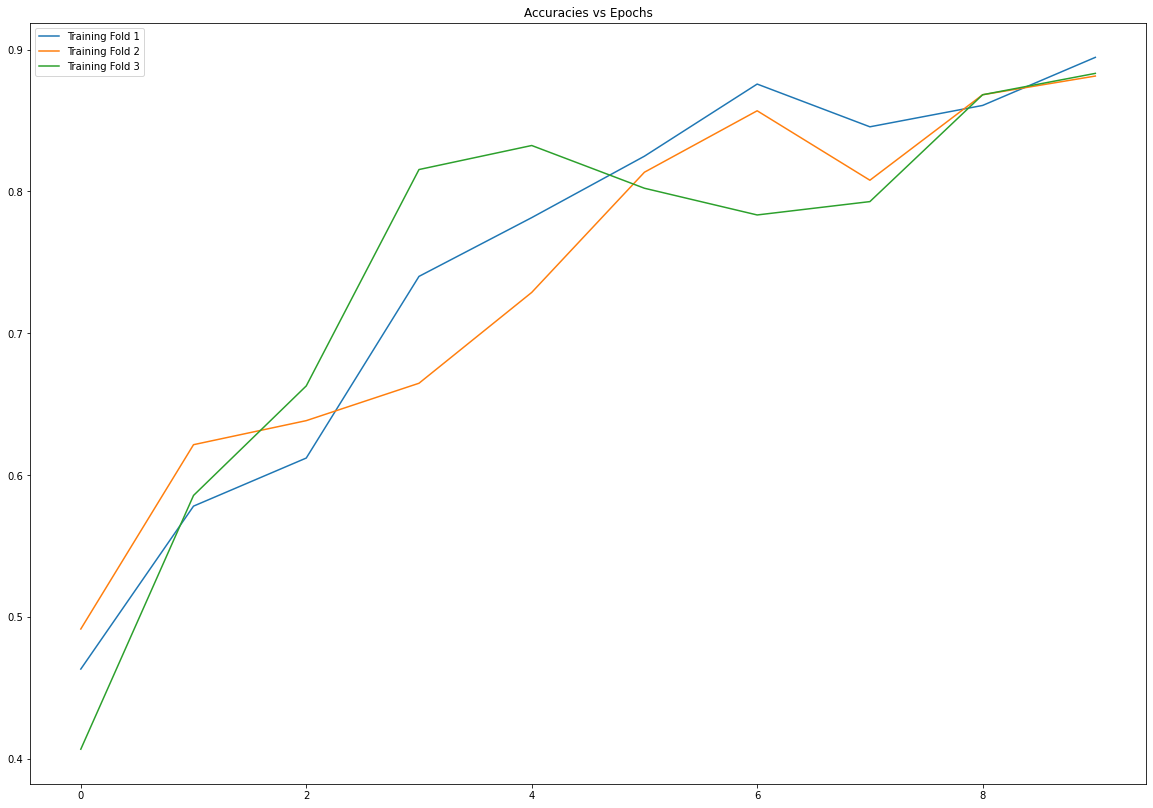

In [0]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')

plt.legend()
plt.show()

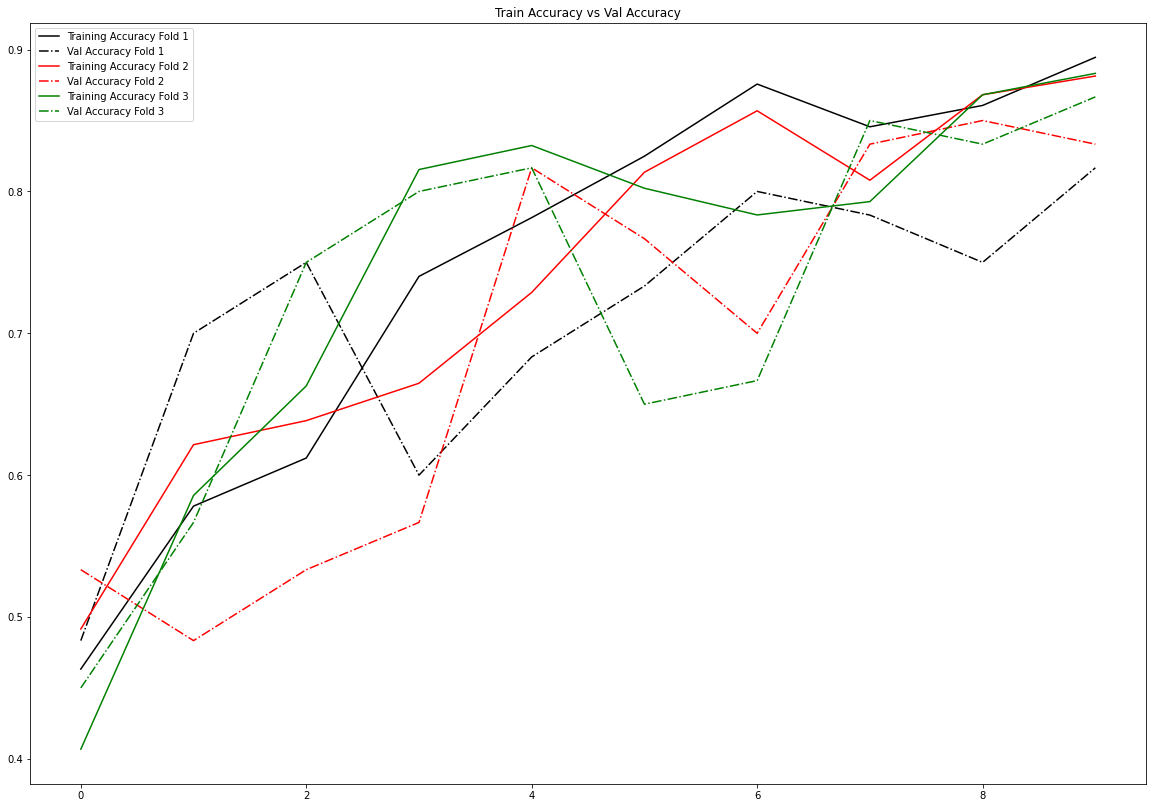

In [0]:
plt.title('Train Accuracy vs Val Accuracy')
 
plt.plot(model_history[0].history['accuracy'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Training Accuracy Fold 3',color='green')

plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")



plt.legend()
plt.show()